In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
import sklearn.calibration
#jtplot.style()

# Functions

Create rolling window of jobs begun or ended in hour prior to each test, or get number of jobs running at the time of each test.

In [36]:
def rollmodel_df(x, dt_col, jobs_running = False, filter_jobs = True):
    y = x.rename(columns = {'DATETIME' : dt_col}).drop(columns = ['JOBID'])
    df = pd.concat([slurm_jobs, y])
    df = df.sort_values(dt_col).reset_index(drop = True)
    if jobs_running == True:
        
        begin_load_df = (df[~df['JOBID'].isnull()]
                                  [['BEGIN']]
                                  .rename(columns={'BEGIN':'TIME'})
                        )
        begin_load_df['process'] = 1
        
        end_load_df = (df[~df['JOBID'].isnull()]
                                  [['END']]
                                  .rename(columns={'END':'TIME'})
                      )
        end_load_df['process'] = -1 
        
        commands_load_df = (df[df['JOBID'].isnull()]
                                  [[dt_col]]
                                  .rename(columns={dt_col:'TIME'})
                      )
        commands_load_df['process'] = 0 
        
        load_df = begin_load_df.append(end_load_df).append(commands_load_df)
        jobs_running_prefilter = load_df.sort_values('TIME')['process'].cumsum()
        jobs_running = jobs_running_prefilter[~jobs_running_prefilter
                                                  .index
                                                  .duplicated(keep='first')]
        df['JOBSRUNNING'+dt_col] = jobs_running
    else:
        df['ROLL1HR'+dt_col] = (df
                                   .rolling('1h', on = dt_col)
                                    ['JOBID']
                                    .count()
                                )
    if filter_jobs == True:
        df = df[df['JOBID'].isnull()]
    else:
        pass
    df = df[(df[dt_col] < '2021-05-18') | (df[dt_col] >= '2021-06-01')]
    return df

Logistic (unwraps Logit)

In [3]:
def logistic(x, a, b):
    return 1/(1+np.exp(-(a + (b*x))))

# Read in ce, filter down to testing
*testing* is the combined server logs (*ce*) filtered down to user 9204 and command type "sbatch".

In [4]:
ce = pd.read_csv('../data/ce.csv')

In [5]:
# Set some datatypes
ce['DATETIME'] = pd.to_datetime(ce['DATETIME'])
ce['UNRESPONSIVE'] = ce['UNRESPONSIVE'].astype('boolean')

In [6]:
testing = ce[ce['TESTING']]

# Read in slurm_jobs
We remove ROLL1HR because we want those values to roll over the *testing* values that we'll concatenate in.

In [7]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [8]:
# Set our datetimes and timedeltas
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [9]:
# We'll put this back in the right context later
slurm_jobs = slurm_jobs.drop(columns = 'ROLL1HR')

# Problem 4

Combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

## (4A) How well correlated is heavy job-ending load with unresponsiveness?

Run the rollmodel_df function defined earlier to do the following:

-- Mix in logs (*testing*) with jobs (*slurm_jobs*)

   * concatenate *slurm_jobs* and testing; call it *slurm_testing_END*
    
-- Create rolling window to check for unresponsivenss

   * sort and reset index of *slurm_testing*
   * create rolling window for jobs completed in hour prior to each entry; call the column ROLL1HR
   * filter slurm_testing down to TESTING == True
   * ensure UNRESPONSIVE is boolean
   * filter out late-May downtime

In [10]:
slurm_testing_END = rollmodel_df(testing, 'END')

### (i) Model with TESTING and jobs ended 
Result: Significant: ROLL1HR and UNRESPONSIVE are (slightly) negatively correlated.

Odds of unresponsiveness decrease by 8% with every thousand jobs ended per hour; e.g. the odds of unresponsiveness at 2000 jobs are predicted to be about 92.7% of what they are at 1000 jobs.

In [11]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12505.
Date:                Tue, 09 Nov 2021   Deviance:                       25011.
Time:                        18:29:30   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7876      0.023   -121.772      0.0

### Plot the model with regular axes

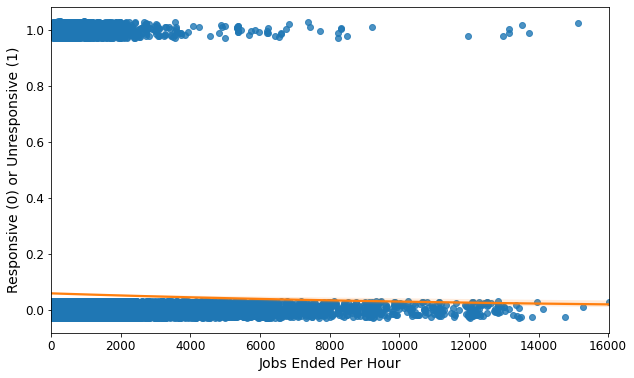

In [12]:
fontsize = 14

fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'ROLL1HREND', 
            y = slurm_testing_END['UNRESPONSIVE'].astype('int'), 
            data = slurm_testing_END, 
            logistic = True, 
            line_kws = {"color": "#FF7F0E"}, 
            y_jitter = 0.03, 
            ax = ax
)

plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Ended Per Hour", fontsize = fontsize);
plt.savefig('../images/jobs_ended_logreg.png', dpi = 600)

## (ii) Build model with all commands (not just USER 9204 and COMMANDTYPE sbatch) and jobs ended
Result: Different coefficients but same takeaway: small negative correlation.

In [13]:
slurm_allcomf = rollmodel_df(ce, 'END')

In [14]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:              9406878
Model:                            GLM   Df Residuals:                  9406876
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2030e+06
Date:                Tue, 09 Nov 2021   Deviance:                   6.4060e+06
Time:                        18:33:43   Pearson chi2:                 9.48e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9778      0.001  -1416.503      0.0

## (iii) Model with TESTING and jobs begun
Result: Different coefficients but same takeaway: small negative correlation.

In [15]:
slurm_testing_BEGIN = rollmodel_df(testing, 'BEGIN')

In [16]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN['ROLL1HRBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12511.
Date:                Tue, 09 Nov 2021   Deviance:                       25023.
Time:                        18:34:02   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8161      0.022   -126.153   

## (iv) Model with TESTING and jobs simultaneously running
Result: Significant: Jobs simultaneously running is positively correlated with unresponsiveness.

In [17]:
slurm_testing_JOBSRUNNING = rollmodel_df(testing, 'BEGIN', True)

In [18]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11991.
Date:                Tue, 09 Nov 2021   Deviance:                       23982.
Time:                        18:34:19   Pearson chi2:                 5.74e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1497      0.081  

### Plot the model

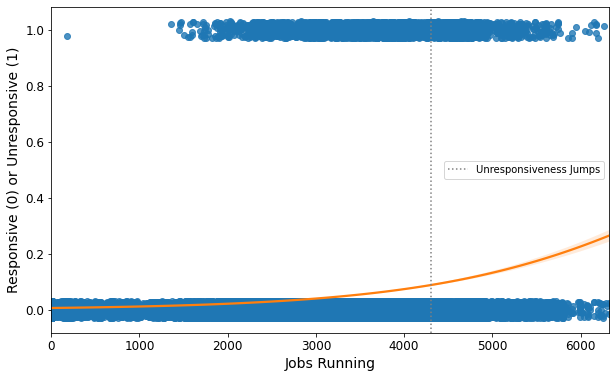

In [19]:
fontsize = 14

fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'JOBSRUNNINGBEGIN', 
            y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
            data = slurm_testing_JOBSRUNNING, 
            logistic = True, 
            line_kws = {"color": "#FF7F0E"}, 
            y_jitter = 0.03, 
            ax = ax
)
ax.axvline(x = 4300, color = 'gray', linestyle = ':', label = 'Unresponsiveness Jumps')
plt.legend()
plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Running", fontsize = fontsize);
plt.savefig('../images/jobs_running_logreg.png', dpi = 600)

### Check the model's calibration
(pretty good)

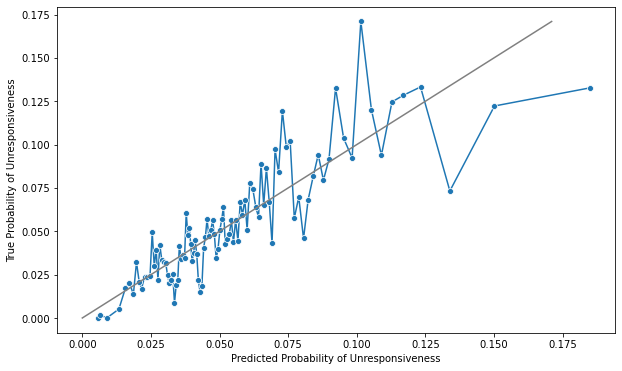

In [20]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
                                slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
                                logreg_unresponsive_roll.fittedvalues,
                                strategy = 'quantile',
                                n_bins = 100
                                     )
fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(x = prob_pred, y = prob_true, ax = ax, marker = 'o')
ax.set(xlabel = 'Predicted Probability of Unresponsiveness',
       ylabel = 'True Probability of Unresponsiveness')
sns.lineplot(x = prob_true, y = prob_true, color = 'gray');
plt.savefig('../images/jobs_running_calibration.png', dpi = 600)

### Look for any thresholds where unresponsiveness jumps
The biggest jump is around 4,300 simultaneous jobs (up to 11.7%)

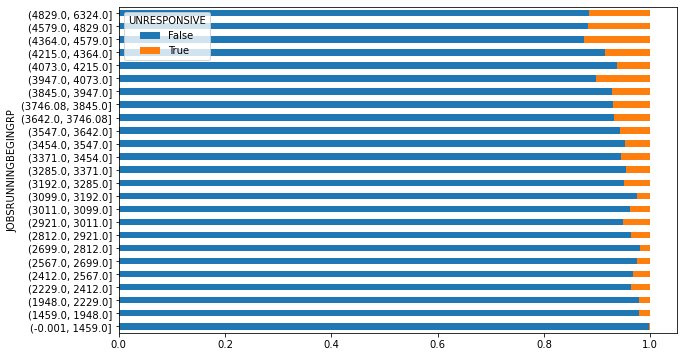

In [82]:
slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.qcut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           q = 25)
fig, ax = plt.subplots(figsize = (10,6))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'barh', 
       stacked = True, 
       ax = ax)
plt.savefig('../images/jobs_running_quantile_probs.png', dpi = 600)

### Confirming the actual percentages of the plot above

In [22]:
(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).tail(24)

JOBSRUNNINGBEGINGRP  UNRESPONSIVE
(3371.0, 3454.0]     False           0.945809
                     True            0.054191
(3454.0, 3547.0]     False           0.952502
                     True            0.047498
(3547.0, 3642.0]     False           0.942833
                     True            0.057167
(3642.0, 3746.08]    False           0.931993
                     True            0.068007
(3746.08, 3845.0]    False           0.929655
                     True            0.070345
(3845.0, 3947.0]     False           0.928205
                     True            0.071795
(3947.0, 4073.0]     False           0.898600
                     True            0.101400
(4073.0, 4215.0]     False           0.938136
                     True            0.061864
(4215.0, 4364.0]     False           0.914015
                     True            0.085985
(4364.0, 4579.0]     False           0.876223
                     True            0.123777
(4579.0, 4829.0]     False           0.883178


### Identifying the maximum predicted probability of unresponsiveness
About 26.5%

In [23]:
logreg_unresponsive_roll.fittedvalues.max()

0.2645790438037419

## (v) Model with all commands and jobs simultaneously running
Result: Still significant: Jobs simultaneously running is positively correlated with unresponsiveness, though with weaker effect

In [24]:
slurm_allcom_JOBSRUNNING = rollmodel_df(ce, 'BEGIN', True)

In [25]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_allcom_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcom_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_allcom_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcom_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:              9406878
Model:                            GLM   Df Residuals:                  9406876
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1530e+06
Date:                Tue, 09 Nov 2021   Deviance:                   6.3061e+06
Time:                        18:38:50   Pearson chi2:                 9.25e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.6070      0.005  

## (vi) Model with all commands and jobs simultaneously running, but reducing to unresponsive events to single entries.
Result: Significant: Jobs simultaneously running is positively correlated with unresponsiveness.

In [26]:
ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DATETIME           datetime64[ns]
 1   USER               int64         
 2   RETRY              int64         
 3   TIMELAPSE          float64       
 4   RETURNCODE         int64         
 5   COMMAND            object        
 6   JOBID              float64       
 7   COMMANDTYPE        object        
 8   TESTING            bool          
 9   UNRESPONSIVE       boolean       
 10  SERVER             object        
 11  UNRESPONSIVEGROUP  float64       
dtypes: bool(1), boolean(1), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 755.7+ MB


In [27]:
unresponsive_intervals = (ce.groupby('UNRESPONSIVEGROUP', as_index = False)
                          ['DATETIME']
                          .apply(lambda x: x.max() - x.min())
                          .rename(columns = {'DATETIME' : 'INTERVALLENGTH'})
                       )
unresponsive_intervals.head(25)

,UNRESPONSIVEGROUP,INTERVALLENGTH
0,4396.0,0 days 00:00:03.591429
1,4408.0,0 days 00:00:00
2,17173.0,0 days 00:00:00
3,17299.0,0 days 00:00:00.383366
4,17542.0,0 days 00:00:00
5,26577.0,0 days 00:00:03.301720
6,26584.0,0 days 00:00:23.284453
7,26646.0,0 days 00:00:20.041339
8,26859.0,0 days 00:00:00
9,26871.0,0 days 00:00:06.884702


In [28]:
ce2 = ce.merge(unresponsive_intervals, how = 'left')

In [29]:
ce2filt = ce2[(~ce2.duplicated('UNRESPONSIVEGROUP'))|(ce2['UNRESPONSIVEGROUP'].isnull())]

In [30]:
slurm_urevents_JOBSRUNNING = rollmodel_df(ce2filt, 'BEGIN', True)

In [31]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_urevents_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_urevents_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_urevents_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_urevents_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:              8481105
Model:                            GLM   Df Residuals:                  8481103
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.8287e+05
Date:                Tue, 09 Nov 2021   Deviance:                   9.6573e+05
Time:                        18:41:08   Pearson chi2:                 8.39e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.9431      0.015  

# Problem Bonus: Make a time-to-failure linear regression model

In [55]:
counter = 0
previous_unresponsive_check = False
def failure_predictor_groups(x):
    """Use a counter to group values leading up to a failure."""
    global counter
    global previous_unresponsive_check
    if pd.isna(x):
        x = False
    else:
        pass
    if (x == False) & (previous_unresponsive_check == True):
        counter += 1
    else:
        pass
    entry = counter
    previous_unresponsive_check = x
    return entry

In [37]:
slurm_JOBSRUNNING = rollmodel_df(x = testing, 
                                         dt_col = 'BEGIN', 
                                         jobs_running = True, 
                                         filter_jobs = False)

In [57]:
slurm_JOBSRUNNING['FAILUREGRP'] = slurm_JOBSRUNNING['UNRESPONSIVE'].apply(lambda x: failure_predictor_groups(x))

In [60]:
slurm_JOBSRUNNING['TIMETOFAILURE'] = slurm_JOBSRUNNING.groupby('FAILUREGRP')['BEGIN'].transform(lambda x: x.max() - x)

In [61]:
slurm_JOBSRUNNING[slurm_JOBSRUNNING['UNRESPONSIVE']]

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,...,RETURNCODE,COMMAND,COMMANDTYPE,TESTING,UNRESPONSIVE,SERVER,UNRESPONSIVEGROUP,JOBSRUNNINGBEGIN,FAILUREGRP,TIMETOFAILURE
413802,NaN,NaN,2020-10-18 06:16:25.392946,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce6,85931.0,3087,2372,0 days 00:00:00
413867,NaN,NaN,2020-10-18 06:38:44.172473,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce6,86766.0,3066,2373,0 days 00:00:00
413943,NaN,NaN,2020-10-18 06:53:44.272915,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,87237.0,3068,2374,0 days 00:00:20.049497
413944,NaN,NaN,2020-10-18 06:54:04.322412,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,87237.0,3068,2374,0 days 00:00:00
414167,NaN,NaN,2020-10-18 07:47:25.825172,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,88831.0,3068,2375,0 days 00:00:20.045836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346109,NaN,NaN,2021-09-24 18:14:35.862916,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,8313794.0,1735,4739,0 days 00:00:00
7346668,NaN,NaN,2021-09-24 19:13:14.894282,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,8314496.0,1961,4740,0 days 00:00:00
7445464,NaN,NaN,2021-10-02 08:14:16.557499,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,8445160.0,3546,4741,0 days 00:00:00
7451902,NaN,NaN,2021-10-02 18:29:08.267199,NaT,NaN,NaN,NaT,NaT,NaN,NaN,...,1.0,"command ['/usr/bin/sbatch', '/tmp/condor_g_scr...",sbatch,True,True,ce5,8453965.0,3569,4742,0 days 00:00:00


In [63]:
slurm_JOBSRUNNINGf = slurm_JOBSRUNNING[~slurm_JOBSRUNNING['JOBID'].isnull()]

In [72]:
slurm_JOBSRUNNINGf['TIMETOFAILUREs'] = slurm_JOBSRUNNINGf['TIMETOFAILURE'].apply(lambda x: x.total_seconds())

<ipython-input-72-e8bad10016ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_JOBSRUNNINGf['TIMETOFAILUREs'] = slurm_JOBSRUNNINGf['TIMETOFAILURE'].apply(lambda x: x.total_seconds())


In [74]:
linreg_unresponsive_base = (sm.GLM(endog = slurm_JOBSRUNNINGf['TIMETOFAILUREs'],
                       exog = sm.add_constant(slurm_JOBSRUNNINGf[[]]),
                       family = sm.families.Gaussian(),
                      )
                  .fit()
               )

linreg_unresponsive_roll = (sm.GLM(endog = slurm_JOBSRUNNINGf['TIMETOFAILUREs'],
                       exog = sm.add_constant(slurm_JOBSRUNNINGf['JOBSRUNNINGBEGIN']),
                       family = sm.families.Gaussian(),
                      )
                  .fit()
               )
print(linreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(linreg_unresponsive_base.aic))
print('Logistic AIC: '+str(linreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:         TIMETOFAILUREs   No. Observations:              7347297
Model:                            GLM   Df Residuals:                  7347295
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                      4.5611e+10
Method:                          IRLS   Log-Likelihood:            -1.0059e+08
Date:                Tue, 09 Nov 2021   Deviance:                   3.3511e+17
Time:                        20:19:11   Pearson chi2:                 3.35e+17
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.747e+05    326.388  

<AxesSubplot:xlabel='JOBSRUNNINGBEGIN', ylabel='JOBSRUNNINGBEGIN'>

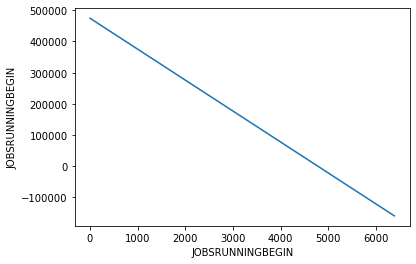

In [77]:
sns.lineplot(x = 'JOBSRUNNINGBEGIN', y = (4.747e+05)-99.2948*slurm_JOBSRUNNINGf['JOBSRUNNINGBEGIN'], data = slurm_JOBSRUNNINGf)

# APPENDIX: Valley of Dry Bones

Original code for checking unresponsiveness

In [ ]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [ ]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [ ]:
#slurm_jobs['END'].apply(check_unresponsive)

George's code for concurrent processes

In [ ]:
# # George's concurrent processes code
# begin_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
# begin_load_df['process'] = 1
# end_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
# end_load_df['process'] = -1 
# load_df = begin_load_df.append(end_load_df)
# resample_interval = "D" 
# fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
# fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()
# plt.figure(figsize=(15, 10))
# plt.plot(fs_resample.index, fs_resample[0])

Useful stripplots with mean hlines

In [ ]:
# fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
# tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

# ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
# ax.axhline(fline)
# ax.axhline(tline, color = '#83A83B')

In [ ]:
# fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
# tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

# ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
# ax.set(yscale = 'log')
# ax.axhline(fline)
# ax.axhline(tline, color = '#83A83B')

datetime diffs from single column and ecdf

In [ ]:
# print(testing['END'].diff().describe())
# x = testing['END'].diff().apply(lambda x: x.total_seconds()).to_frame()
# sns.displot(x,  
#             kind = 'ecdf',
#            )
# plt.xlim(0.001, 1800)

Some plot templates used before switching to regplot()

In [ ]:
# fontsize = 16

# fig, ax = plt.subplots(figsize = (10,6))

# x = slurm_testing_END['ROLL1HREND']
# y_logistic = logistic(x = x, a = -2.7876, b =-7.347e-05)
# plt.scatter(x, y_logistic, label = 'Logistic')

# x = slurm_testing_END['ROLL1HREND']
# y = slurm_testing_END['UNRESPONSIVE'].astype('int')
# plt.scatter(x, y, label = 'Actual', alpha = 0.5)
# #ax.axhline(0.5)
# plt.legend()
# #plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
# plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
# plt.yticks(fontsize = fontsize - 2)
# plt.xticks(fontsize = fontsize - 2)
# plt.xlabel("Jobs Ended Per Hour", fontsize = fontsize);


In [ ]:
# fig, ax = plt.subplots(figsize = (10,6))

# x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
# y_logistic = logistic(x = x, a = -5.1497, b =0.0007)
# plt.scatter(x, y_logistic, label = 'Logistic')

# x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
# y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int')
# plt.scatter(x, y, label = 'Actual', alpha = 0.5)
# #ax.axhline(0.5)
# plt.legend()
# plt.title("Logistic Regression Model Predicts Unresponsiveness Increases as Jobs Running Increases")
# plt.ylabel("Responsive (0) or Unresponsive (1)")
# plt.xlabel("Jobs Running");